# Updated Cooling Center Notebook
February 28, 2025

The purpose of this assignment is to conduct spatial autocorrelation to find out if cooling center locations have a statistical significant tendency to cluster in certain census tracts in LA County. Our approach is:

- import census tracts boundaries for Los Angeles
- import cooling center data from the LA Ready (building off of previous code on cooling centers for our final project) 
- spatially join the two datasets

(Jump to the bottom of the notebook for Spatial Autocorrelation)

- normalize the data to create cooling centers per 4,000(avg. number of people in census tracts in LA) 
- conduct global spatial autocorrelation using Moran's I
- conduct local spatial autocorrelation using Local Indicators of Spatial Association (LISAs)

In [1]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

#for distance calculations 
from shapely.geometry import Point
import numpy as np

### Read into our first dataset, LA County Cooling Centers

In [2]:
#read into Cooling Center data downloaded from LA Ready 
centers = pd.read_csv("data/GeocodeResultsCleaned_CoolingCenters(Sheet0).csv", encoding='windows-1254')

In [3]:
centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   RECORD ID NUMBER                     190 non-null    object 
 1   INPUT ADDRESS                        190 non-null    object 
 2   TIGER ADDRESS RANGE MATCH INDICATOR  190 non-null    object 
 3   TIGER MATCH TYPE                     175 non-null    object 
 4   TIGER OUTPUT ADDRESS                 190 non-null    object 
 5   LONGITUDE                            190 non-null    float64
 6   LATITUDE                             190 non-null    float64
 7   TIGERLINE ID                         175 non-null    float64
 8   TIGERLINE ID SIDE                    175 non-null    object 
 9   STATE CODE                           190 non-null    int64  
 10  COUNTY CODE                          190 non-null    int64  
 11  TRACT CODE                      

In [4]:
#identify column names
centers.columns

Index(['RECORD ID NUMBER', 'INPUT ADDRESS ',
       'TIGER ADDRESS RANGE MATCH INDICATOR', 'TIGER MATCH TYPE',
       'TIGER OUTPUT ADDRESS', 'LONGITUDE ', 'LATITUDE', 'TIGERLINE ID',
       'TIGERLINE ID SIDE', 'STATE CODE', 'COUNTY CODE', 'TRACT CODE',
       'BLOCK CODE'],
      dtype='object')

In [5]:
#rename the longitude column, which was a following space attached to its name from the original download
centers = centers.rename(columns={'LONGITUDE ': 'LONGITUDE', 'INPUT ADDRESS ': 'Address', 'RECORD ID NUMBER' : 'Name'})

In [6]:
#convert column names to lowercase 
centers.columns = centers.columns.str.lower()
centers.columns

Index(['name', 'address', 'tiger address range match indicator',
       'tiger match type', 'tiger output address', 'longitude', 'latitude',
       'tigerline id', 'tigerline id side', 'state code', 'county code',
       'tract code', 'block code'],
      dtype='object')

In [7]:
#convert the state, tract and county codes to a string in order to create a FIPs string
centers[['state code', 'tract code', 'county code']] = centers[['state code', 'tract code', 'county code']].astype(str)

In [8]:
centers['state code']

0      6
1      6
2      6
3      6
4      6
      ..
185    6
186    6
187    6
188    6
189    6
Name: state code, Length: 190, dtype: object

In [9]:
#create a FIPS column, which will later be used to merge with the census tract data set 
centers['FIPS'] = '0' + centers['state code'] + centers['county code'] + centers['tract code']
centers['FIPS'].head()

0    0637106111
1    0637108102
2    0637311000
3    0637541100
4    0637540902
Name: FIPS, dtype: object

In [10]:
#split address by street, city, zip to extract city to understand which cities have higher concentrations of centers
centers[['street', 'city', 'zip']] = centers["address"].str.split(",", n=2, expand=True)
centers['city']

0             Sylmar
1       Porter Ranch
2            Burbank
3            Compton
4       Los Angeles 
           ...      
185      Los Angeles
186       Montebello
187             Bell
188     La Crescenta
189         Van Nuys
Name: city, Length: 190, dtype: object

In [11]:
#strip by trailing characters on the right side of the string
centers['city'] = centers['city'].str.rstrip()

In [12]:
centers.columns

Index(['name', 'address', 'tiger address range match indicator',
       'tiger match type', 'tiger output address', 'longitude', 'latitude',
       'tigerline id', 'tigerline id side', 'state code', 'county code',
       'tract code', 'block code', 'FIPS', 'street', 'city', 'zip'],
      dtype='object')

In [13]:
# Indices of columns to drop
column_indices_to_drop = [2,3,4,7,8,9,10]

# Drop columns by index
centers = centers.drop(centers.columns[column_indices_to_drop], axis=1)

In [14]:
centers.head()

,name,address,longitude,latitude,tract code,block code,FIPS,street,city,zip
0,Veteran's Memorial Community Regional Park,"13000 Sayre St, Sylmar, 91342",-118.417156,34.324843,106111,2003,0637106111,13000 Sayre St,Sylmar,91342
1,Porter Ranch Branch Library,"11371 Tampa Avenue, Porter Ranch, 91326",-118.558526,34.276780,108102,1000,0637108102,11371 Tampa Avenue,Porter Ranch,91326
2,Northwest Library,"3323 W. Victory Blvd., Burbank, 91505",-118.347214,34.184764,311000,3017,0637311000,3323 W. Victory Blvd.,Burbank,91505
3,Roy Campanella Park,"14812 S Stanford Ave, Compton, 90220",-118.261095,33.898681,541100,3001,0637541100,14812 S Stanford Ave,Compton,90220
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,0637540902,150 E El Segundo Blvd,Los Angeles,90061


In [15]:
#create a geometry column to create a single geographic locaiton point using the provided longitude and latitude points
centers['geometry'] = gpd.points_from_xy(centers.longitude, centers.latitude)

In [16]:
#convert centers into a geopandas 
centers = gpd.GeoDataFrame(centers, 
                           crs='epsg: 4326', #second parameter is the crs code
                           geometry=centers['geometry']) #thrid parameter is geometry which needs to know which long/lat points to map to
centers.head()

,name,address,longitude,latitude,tract code,block code,FIPS,street,city,zip,geometry
0,Veteran's Memorial Community Regional Park,"13000 Sayre St, Sylmar, 91342",-118.417156,34.324843,106111,2003,0637106111,13000 Sayre St,Sylmar,91342,POINT (-118.41716 34.32484)
1,Porter Ranch Branch Library,"11371 Tampa Avenue, Porter Ranch, 91326",-118.558526,34.276780,108102,1000,0637108102,11371 Tampa Avenue,Porter Ranch,91326,POINT (-118.55853 34.27678)
2,Northwest Library,"3323 W. Victory Blvd., Burbank, 91505",-118.347214,34.184764,311000,3017,0637311000,3323 W. Victory Blvd.,Burbank,91505,POINT (-118.34721 34.18476)
3,Roy Campanella Park,"14812 S Stanford Ave, Compton, 90220",-118.261095,33.898681,541100,3001,0637541100,14812 S Stanford Ave,Compton,90220,POINT (-118.2611 33.89868)
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,0637540902,150 E El Segundo Blvd,Los Angeles,90061,POINT (-118.27209 33.91637)


In [17]:
#check that the df is now a geopandas df 
type(centers)

geopandas.geodataframe.GeoDataFrame

### Analyzing distance between centers 

In [18]:
#find distance between centers by importing numpy 
def avg_dist(df):
    # List of points (replace with your full dataset)
    coords = [(point.x, point.y) for point in df.geometry]
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in coords], crs="EPSG:4326") 
    
    # Reproject to a suitable CRS (EPSG:2229 for LA County in feet, EPSG:26945 for meters)
    gdf = gdf.to_crs(epsg=2229)  # Use 26945 if you prefer meters
    
    # Compute pairwise distance matrix
    dist_matrix = gdf.geometry.apply(lambda g: gdf.distance(g))
    
    # Extract upper triangle (excluding diagonal)
    distances = dist_matrix.to_numpy()
    upper_triangle = distances[np.triu_indices(len(gdf), k=1)]
    
    # Compute average distance
    average_distance_feet = round(upper_triangle.mean(), 2)
    average_distance_miles = round((average_distance_feet / 5280), 2)
    return average_distance_miles

In [19]:
avg_dist_LA_County = avg_dist(centers)
print("The average distance between centers in LA county is " + str(avg_dist_LA_County) + " miles.")

The average distance between centers in LA county is 20.3 miles.


In [20]:
#look specifically at centers in the city of LA 
LA_centers = centers[centers['city'] == ' Los Angeles']

In [21]:
LA_centers

,name,address,longitude,latitude,tract code,block code,FIPS,street,city,zip,geometry
4,A C Bilbrew Library,"150 E El Segundo Blvd , Los Angeles , 90061",-118.272094,33.916366,540902,3002,0637540902,150 E El Segundo Blvd,Los Angeles,90061,POINT (-118.27209 33.91637)
5,Col. Leon H. Washington Park,"8908 Maie Ave, Los Angeles, 90002",-118.244150,33.953341,535200,1000,0637535200,8908 Maie Ave,Los Angeles,90002,POINT (-118.24415 33.95334)
10,John Muir Branch Library,"1005 W. 64th Street, Los Angeles, 90044",-118.292070,33.981487,237401,2001,0637237401,1005 W. 64th Street,Los Angeles,90044,POINT (-118.29207 33.98149)
11,East Los Angeles Service Center,"133 N. Sunol Drive, Los Angeles, 90063",-118.178697,34.036756,531102,1006,0637531102,133 N. Sunol Drive,Los Angeles,90063,POINT (-118.1787 34.03676)
13,Robertson Branch Library,"1719 S. Robertson Boulevard, Los Angeles, 90035",-118.385683,34.048454,217001,1013,0637217001,1719 S. Robertson Boulevard,Los Angeles,90035,POINT (-118.38568 34.04845)
...,...,...,...,...,...,...,...,...,...,...,...
169,Malabar Branch Library,"2801 Wabash Avenue, Los Angeles, 90033",-118.197889,34.050512,203200,1005,0637203200,2801 Wabash Avenue,Los Angeles,90033,POINT (-118.19789 34.05051)
170,Pico Union Branch Library,"1030 S. Alvarado Street, Los Angeles, 90006",-118.280076,34.051233,209520,2003,0637209520,1030 S. Alvarado Street,Los Angeles,90006,POINT (-118.28008 34.05123)
177,East L.A./West San Gabriel Valley Comprehensiv...,"5301 Whittier Blvd. 2nd Floor, Los Angeles, 90022",-118.155715,34.020561,531701,2008,0637531701,5301 Whittier Blvd. 2nd Floor,Los Angeles,90022,POINT (-118.15572 34.02056)
178,Jefferson - Vassie D. Wright Memorial Branch ...,"2211 W. Jefferson Boulevard, Los Angeles, 90018",-118.319209,34.026104,219010,1009,0637219010,2211 W. Jefferson Boulevard,Los Angeles,90018,POINT (-118.31921 34.0261)


In [22]:
avg_dist_LA_City = avg_dist(LA_centers)
print("The average distance between centers in the city of LA is " + str(avg_dist_LA_City) + " miles.")

The average distance between centers in the city of LA is 7.49 miles.


### Read into our second dataset, census tracts in LA, and clean 

In [23]:
#read into the geojson file downloaded from the US Census Reporter  
tracts = gpd.read_file("data/acs2023_5yr_B01003_14000US06037575001.geojson")

In [24]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2499 non-null   object  
 1   name              2499 non-null   object  
 2   B01003001         2499 non-null   float64 
 3   B01003001, Error  2498 non-null   float64 
 4   geometry          2499 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 97.7+ KB


In [25]:
tracts.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2499 non-null   object  
 1   name              2499 non-null   object  
 2   B01003001         2499 non-null   float64 
 3   B01003001, Error  2498 non-null   float64 
 4   geometry          2499 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 97.7+ KB


In [26]:
# trim the data to the bare minimum columns
tracts = tracts[['geoid','B01003001','geometry']]

# rename the columns
tracts.columns = ['FIPS','TotalPop','geometry']
tracts['FIPS'] = tracts['FIPS'].str.replace('14000US06037','') #replace 15,000 US with nothing since every row has this US identifier in FIPS 
tracts.head()

,FIPS,TotalPop,geometry
0,05000US06037,9848406.0,"MULTIPOLYGON (((-118.6782 33.03973, -118.6756 ..."
1,101110,4152.0,"MULTIPOLYGON (((-118.30229 34.2587, -118.30091..."
2,101122,4198.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
3,101220,3434.0,"MULTIPOLYGON (((-118.28592 34.25404, -118.2859..."
4,101221,3931.0,"MULTIPOLYGON (((-118.29792 34.25597, -118.2969..."


In [27]:
# delete first row which is for the entire county of LA
tracts.drop(tracts.head(1).index,inplace=True) #1 is the first value of the tail and index resets the index

In [28]:
#subset data with pop less than 100 out of df 
tracts = tracts[tracts['TotalPop']>100]

In [29]:
tracts.shape

(2468, 3)

### Plot tracts and cooling centers on a map 

In [30]:
tracts = tracts.to_crs(epsg=3857) #keep consistent projection 

<Axes: >

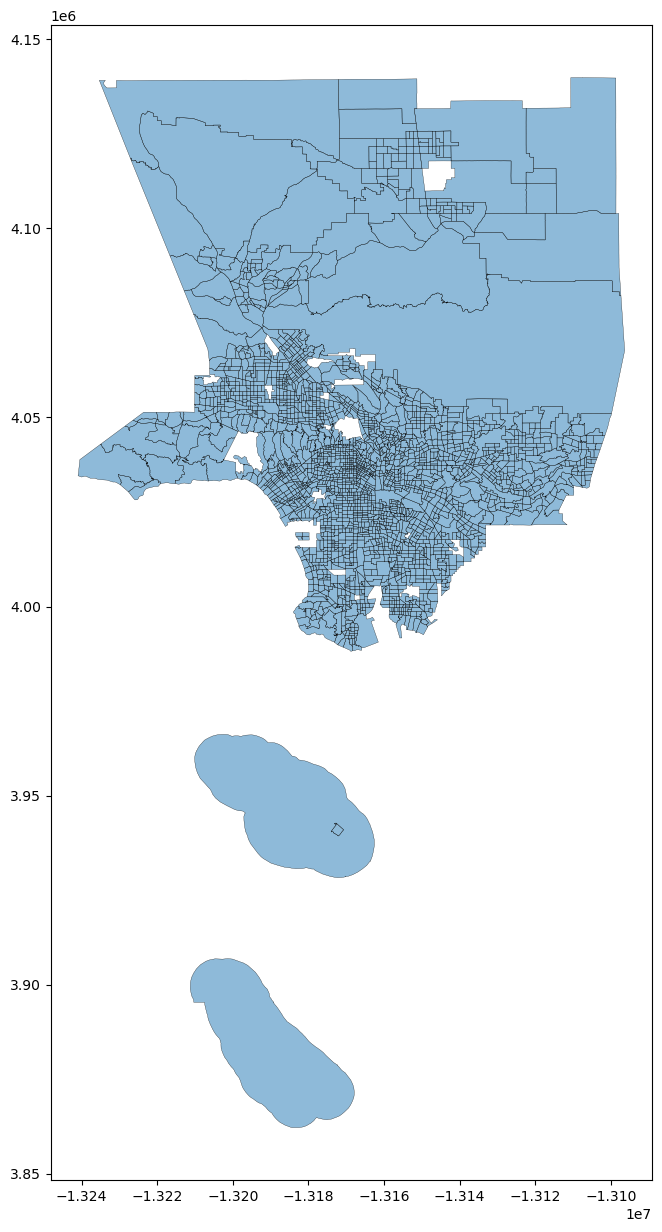

In [31]:
fig,ax = plt.subplots(figsize=(15,15))
tracts.plot(ax=ax,zorder=10,alpha=0.5) #z is lowest layer on the plot, alpha is transparency
tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=0.2)

In [32]:
centers = centers.to_crs(epsg=3857)

In [33]:
# get the bounding box coordinates for the centers data
minx, miny, maxx, maxy = centers.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13224683.415738665
-13104123.360806333
3993459.184591898
4123719.9021027423


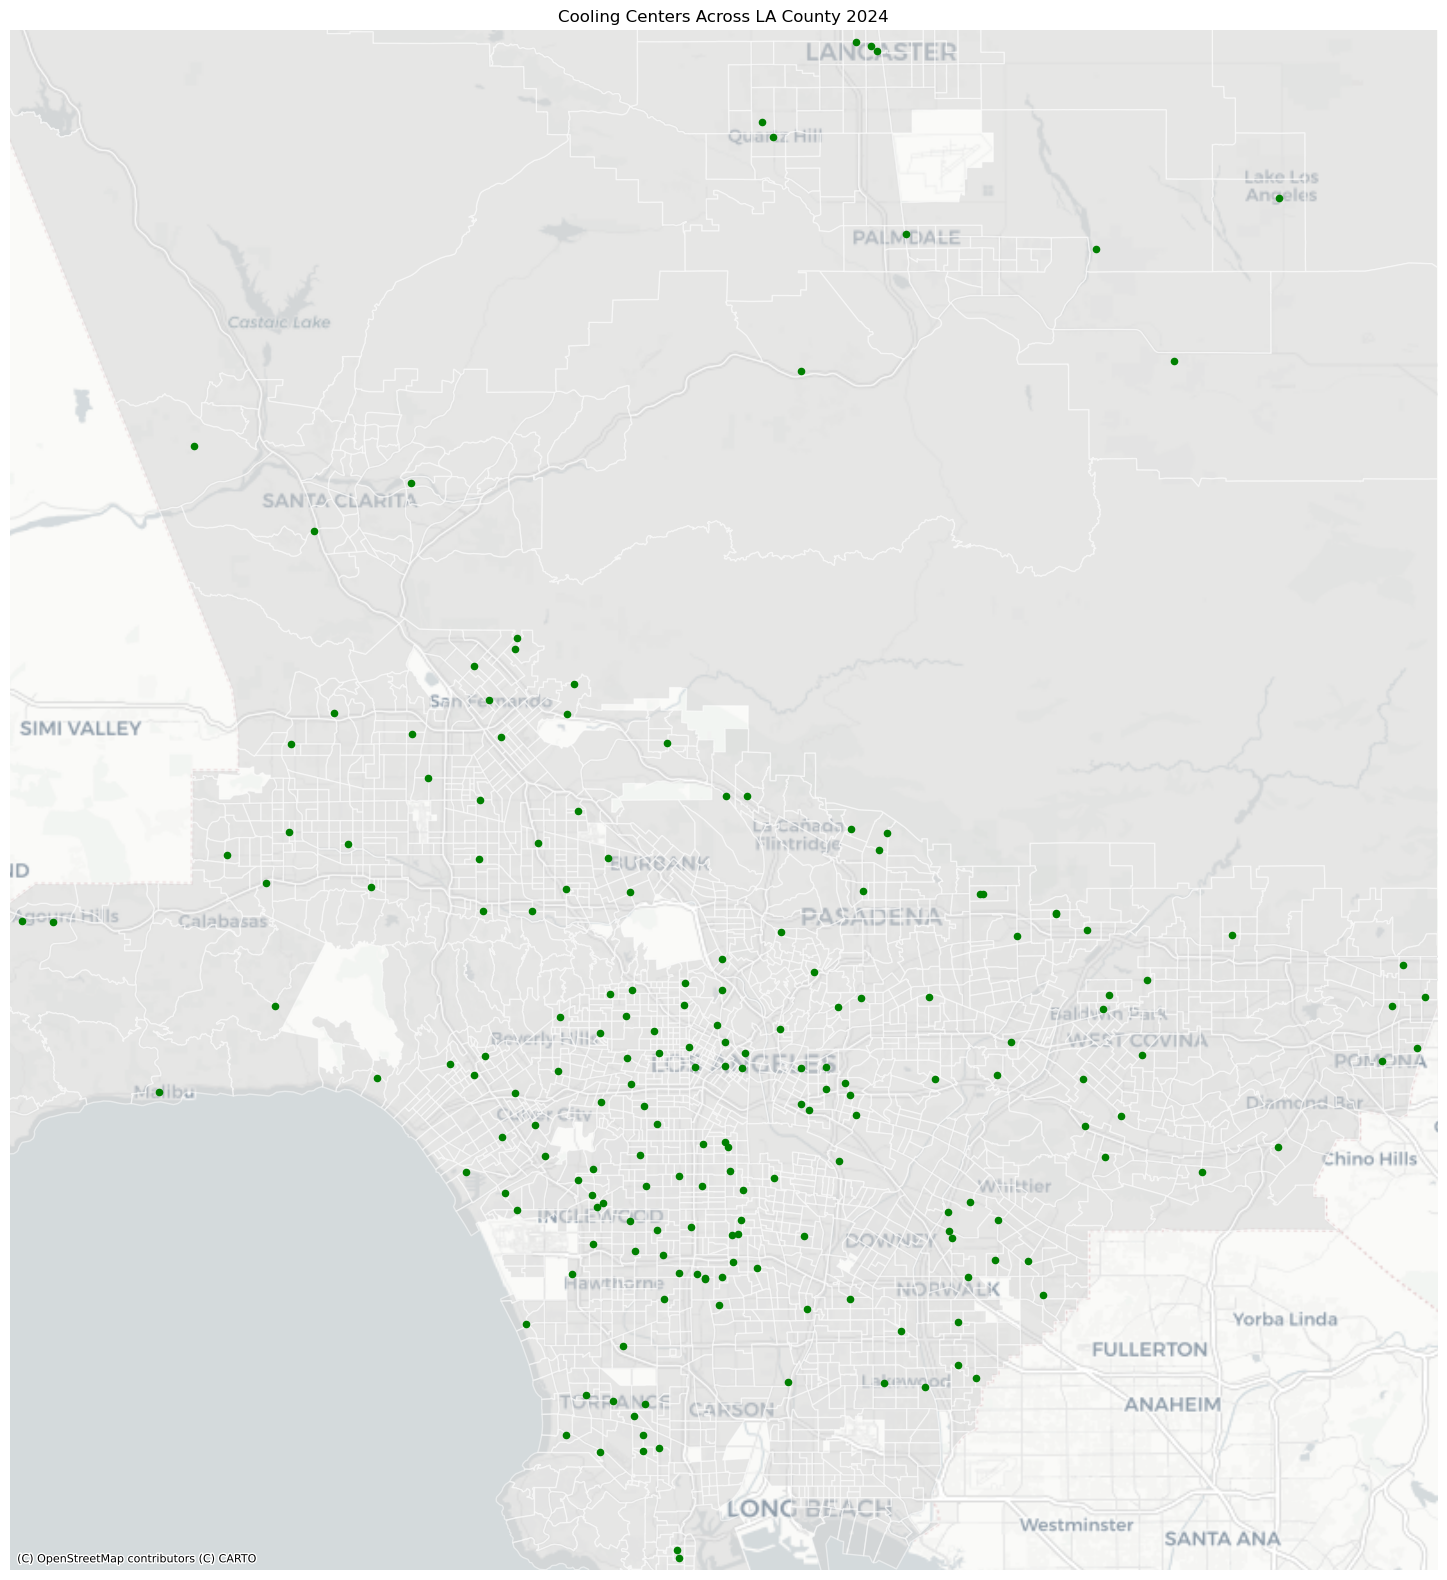

In [34]:
fig, ax = plt.subplots(figsize=(20, 20))

# plot tracts
tracts.plot(ax=ax, # this puts it in the ax plot
        color='lightgray', 
        edgecolor='white',
        alpha=0.5)

# add centers to the plot 
centers.plot(ax=ax, #plot it here in ax in the empty sublot 
        marker='o', #instead of default marker, mark with an X
        markersize=20,
        color='green')

# turn the axes off
ax.axis('off')

ax.set_title('Cooling Centers Across LA County 2024')

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

### Explore where census tracts are located 
Before merging the dataset, find the average number of centers per census tract.

In [35]:
totalTracts = len(tracts.FIPS)
totalCenters = len(centers["name"])

print("There are " + str(totalCenters) + " cooling centers across LA County.")


There are 190 cooling centers across LA County.


In [36]:
totalTracts

2468

In [37]:
centerPerTract= totalCenters / totalTracts
centerPerTract

0.07698541329011345

In [38]:
centerPerTractPercent = round(centerPerTract * 100, 2)
print("" + str(centerPerTractPercent) + " of census tracts in LA County have a cooling center.")

7.7 of census tracts in LA County have a cooling center.


### Calculate Population Statistics 

In [39]:
# count the number of centers per tract
centers_by_tract = centers.value_counts(centers['tract code']).reset_index(name='centers_count').sort_values(by='centers_count', ascending=False)
centers_by_tract['FIPS'] = centers_by_tract['tract code']
centers_by_tract

,tract code,centers_count,FIPS
0,104124,2,104124
1,106111,2,106111
2,228710,2,228710
3,535200,2,535200
4,540902,2,540902
...,...,...,...
174,911001,1,911001
175,911100,1,911100
176,920048,1,920048
177,920106,1,920106


In [40]:
tracts = pd.merge(tracts, centers_by_tract, on= 'FIPS', how='left')
#df = pd.merge(a, b, on='id', how='left')
tracts

,FIPS,TotalPop,geometry,tract code,centers_count
0,101110,4152.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",101110,1.0
1,101122,4198.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",NaN,NaN
2,101220,3434.0,"MULTIPOLYGON (((-13167528.828 4062965.287, -13...",NaN,NaN
3,101221,3931.0,"MULTIPOLYGON (((-13168864.105 4063224.413, -13...",NaN,NaN
4,101222,2572.0,"MULTIPOLYGON (((-13168465.581 4062734.852, -13...",NaN,NaN
...,...,...,...,...,...
2463,980024,205.0,"MULTIPOLYGON (((-13193418.068 4053521.172, -13...",NaN,NaN
2464,980025,442.0,"MULTIPOLYGON (((-13165155.719 4008337.305, -13...",NaN,NaN
2465,980031,970.0,"MULTIPOLYGON (((-13168099.229 3995788.284, -13...",NaN,NaN
2466,980035,642.0,"MULTIPOLYGON (((-13135477.609 4032787.081, -13...",NaN,NaN


In [41]:
tract_morethan1 = centers_by_tract[centers_by_tract['centers_count'] >= 2]
print("There are " + str(len(tract_morethan1)) + " census tracts with 2 or more centers.")

There are 11 census tracts with 2 or more centers.


In [42]:
#print census tract code
for x in tract_morethan1['tract code']:
    print(x)

104124
106111
228710
535200
540902
800335
900806
431004
430502
504200
296600


In [43]:
tract_just1 = centers_by_tract[centers_by_tract['centers_count'] == 1]
print("There are " + str(len(tract_just1)) + " census tracts with only 1 center.")

There are 168 census tracts with only 1 center.


In [44]:
#count the number of centers per CITY 
centers_by_city = centers.value_counts('city').reset_index(name='count').sort_values(by='count', ascending=False)
city_morethan1 = centers_by_city[centers_by_city['count'] >= 2]
city_morethan1

,city,count
0,Los Angeles,64
1,Inglewood,6
2,Torrance,6
3,Sylmar,4
4,Compton,4
5,Whittier,4
6,Lancaster,3
7,Pomona,3
8,Altadena,3
9,Hacienda Heights,2


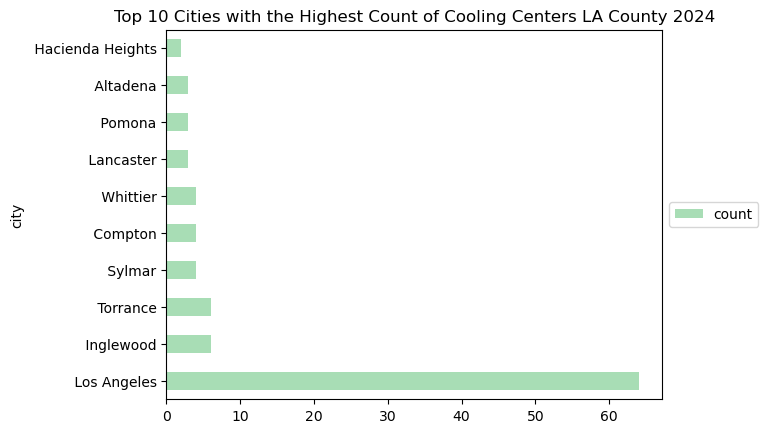

In [45]:
ax = city_morethan1.head(10).plot.barh(x='city',
                                   y='count',
                                   title= 'Top 10 Cities with the Highest Count of Cooling Centers LA County 2024',
                                   color = '#a8ddb5')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.figure.savefig('top_10_cities_centers.png', bbox_inches='tight')

Because we want to understand general trends about centers in LA County, we chose to look at count per city rather than census tracts, which do not provide much information to an average citizen. According to the data, Los Angeles has the highest count of centers, followed by Inglewood and Torrance.

In [46]:
#use describe calculation for general descriptive statistics
centers_by_tract['centers_count'].describe()

count    179.000000
mean       1.061453
std        0.240832
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: centers_count, dtype: float64

### Calculate Population Statistics 

In [47]:
#calculate avg population 
TotalPop = sum(tracts.TotalPop)
totalTracts = len(tracts.FIPS)
peoplePerTract = TotalPop / totalTracts
peoplePerTract

3990.3164505672607

Because there are an average of ~4,000 people per census tract, we want to normalize the data by calculating center per 4,000 people.  

### Normalize data

In [48]:
tracts['centers_per_4000'] = tracts['centers_count']/tracts['TotalPop']*1000

In [49]:
tracts.sort_values(by="centers_per_4000").head()

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
1028,275604,10392.0,"MULTIPOLYGON (((-13183554.382 4025066.42, -131...",275604,1.0,0.096228
2277,702900,8844.0,"MULTIPOLYGON (((-13187282.249 4026266.782, -13...",702900,1.0,0.113071
1603,502303,8229.0,"MULTIPOLYGON (((-13145589.982 4024395.819, -13...",502303,1.0,0.121521
1610,502700,7569.0,"MULTIPOLYGON (((-13146058.304 4022177.987, -13...",502700,1.0,0.132118
2398,911100,7331.0,"MULTIPOLYGON (((-13149164.563 4109899.923, -13...",911100,1.0,0.136407


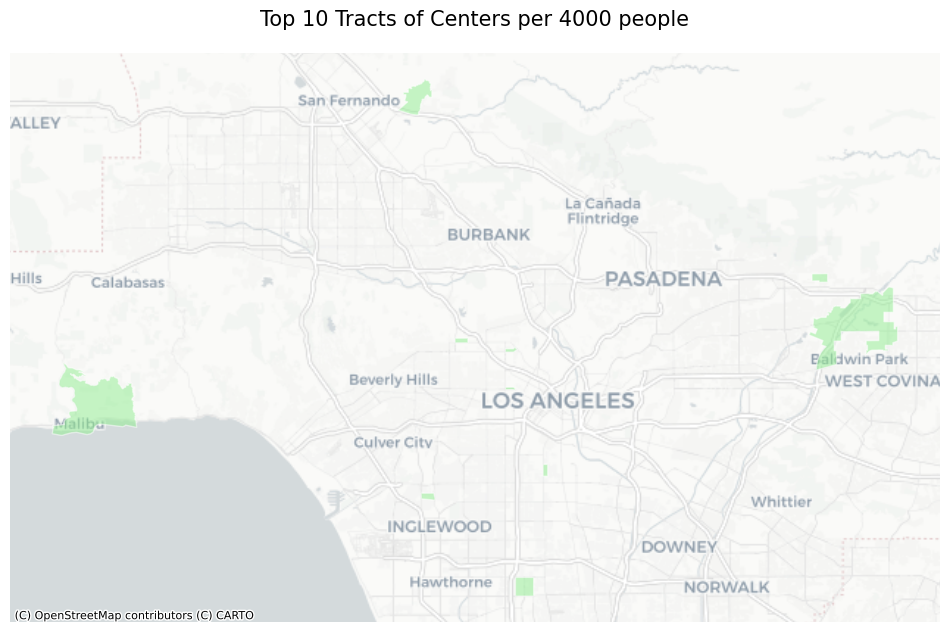

In [50]:
# map the top 10 geographies with centers per 4,000 people 
fig,ax = plt.subplots(figsize=(12,10))
tracts.sort_values(by='centers_per_4000',ascending=False)[:10].plot(ax=ax,
                                                                 color='lightgreen',
                                                                 edgecolor='white',
                                                                 alpha=0.5)
# title
ax.set_title('Top 10 Tracts of Centers per 4000 people',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [51]:
tracts.head()

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
0,101110,4152.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",101110,1.0,0.240848
1,101122,4198.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",NaN,NaN,NaN
2,101220,3434.0,"MULTIPOLYGON (((-13167528.828 4062965.287, -13...",NaN,NaN,NaN
3,101221,3931.0,"MULTIPOLYGON (((-13168864.105 4063224.413, -13...",NaN,NaN,NaN
4,101222,2572.0,"MULTIPOLYGON (((-13168465.581 4062734.852, -13...",NaN,NaN,NaN


In [52]:
#drop null values so we can only focus on census tracts with centers
tractswithCenters = tracts.dropna()

There should only be 179 rows, since there are only 179 census tracts with cooling centers based on the above data 

In [53]:
tractswithCenters

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000
0,101110,4152.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",101110,1.0,0.240848
21,104124,4090.0,"MULTIPOLYGON (((-13179315.447 4066141.344, -13...",104124,2.0,0.488998
30,104404,3374.0,"MULTIPOLYGON (((-13184154.06 4064004.388, -131...",104404,1.0,0.296384
43,106111,4707.0,"MULTIPOLYGON (((-13182603.157 4071231.574, -13...",106111,2.0,0.424899
53,106520,5484.0,"MULTIPOLYGON (((-13188354.923 4070518.351, -13...",106520,1.0,0.182349
...,...,...,...,...,...,...
2397,911001,3546.0,"MULTIPOLYGON (((-13139199.242 4096495.376, -13...",911001,1.0,0.282008
2398,911100,7331.0,"MULTIPOLYGON (((-13149164.563 4109899.923, -13...",911100,1.0,0.136407
2421,920048,5502.0,"MULTIPOLYGON (((-13191875.18 4086032.342, -131...",920048,1.0,0.181752
2426,920106,3576.0,"MULTIPOLYGON (((-13216571.854 4092694.054, -13...",920106,1.0,0.279642


### Conduct Global Spatial Autocorrelation 

We will use Global Moran's I statistic to *quantify* the degree to which similar geographies are clustered. We compare each geography based on a given value (in this case centers counts) with that of its neighbors. First, we need to apply a spatial weight. We use the KNN spatial weight, where `k` is the number of "nearest neighbors" to count in the calculations. We decided to use`k=8` for our KNN spatial weights. 

We also **row standardize** the data to adjust the weights in a spatial weights matrix. When weights are row standardized, each weight is divided by its row sum. The row sum is the sum of weights for a features neighbors.

### Apply spatial weight 

In [54]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(tractswithCenters,k=8)

# Row-standardization
wq.transform = 'r'

### Spatial lag

We use our spatial weights to calculate the spatial lag. The spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. <b> It takes the average of all the neighbors as defined by the spatial weight to come up with a single associated value. </b>

In [55]:
# create a new column for the spatial lag
tractswithCenters['centers_per_4000_lag'] = lps.weights.lag_spatial(wq, tractswithCenters['centers_per_4000']) #arguments are the weights and then the centers

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
# take a look at some sample rows
tractswithCenters.head(10)[['FIPS','TotalPop','centers_count','centers_per_4000','centers_per_4000_lag']]

,FIPS,TotalPop,centers_count,centers_per_4000,centers_per_4000_lag
0,101110,4152.0,1.0,0.240848,0.274232
21,104124,4090.0,2.0,0.488998,0.299337
30,104404,3374.0,1.0,0.296384,0.298327
43,106111,4707.0,2.0,0.424899,0.296520
53,106520,5484.0,1.0,0.182349,0.316934
66,108102,3477.0,1.0,0.287604,0.236346
92,111402,5998.0,1.0,0.166722,0.273455
108,113323,3904.0,1.0,0.256148,0.260098
133,117303,4162.0,1.0,0.240269,0.272157
160,120104,2603.0,1.0,0.384172,0.252791


In [57]:
# create a column that calculates the difference between centers and lag
tractswithCenters['centers_lag_diff'] = tractswithCenters['centers_per_4000'] - tractswithCenters['centers_per_4000_lag']
# output to get the head and tail
tractswithCenters.sort_values(by='centers_lag_diff')

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1168,311700,5852.0,"MULTIPOLYGON (((-13172594.532 4050990.776, -13...",311700,1.0,0.170882,0.384765,-0.213883
2085,601302,6513.0,"MULTIPOLYGON (((-13177202.38 4024458.77, -1317...",601302,1.0,0.153539,0.340700,-0.187161
1028,275604,10392.0,"MULTIPOLYGON (((-13183554.382 4025066.42, -131...",275604,1.0,0.096228,0.270665,-0.174437
508,195100,4976.0,"MULTIPOLYGON (((-13166525.171 4041677.596, -13...",195100,1.0,0.200965,0.363609,-0.162644
604,207712,4927.0,"MULTIPOLYGON (((-13164622.721 4034941.281, -13...",207712,1.0,0.202963,0.363243,-0.160280
...,...,...,...,...,...,...,...,...
2084,601301,1888.0,"MULTIPOLYGON (((-13176926.085 4026336.456, -13...",601301,1.0,0.529661,0.283279,0.246382
2328,900806,4342.0,"MULTIPOLYGON (((-13152186.775 4123624.877, -13...",900806,2.0,0.460617,0.204383,0.256234
466,190701,1643.0,"MULTIPOLYGON (((-13173403.269 4042445.202, -13...",190701,1.0,0.608643,0.338700,0.269943
1402,431004,3343.0,"MULTIPOLYGON (((-13136302.931 4049135.52, -131...",431004,2.0,0.598265,0.281104,0.317161


In order to better understand the significance of the spatial lag values, consider the following two geographies: the donut and the diamond

In [58]:
# find the donut aka the tract with highest negative difference
donut = tractswithCenters.sort_values(by='centers_lag_diff').head(1)
donut

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1168,311700,5852.0,"MULTIPOLYGON (((-13172594.532 4050990.776, -13...",311700,1.0,0.170882,0.384765,-0.213883


In [59]:
# the FIPS with highest positive difference
diamond = tractswithCenters.sort_values(by='centers_lag_diff').tail(1)
diamond

,FIPS,TotalPop,geometry,tract code,centers_count,centers_per_4000,centers_per_4000_lag,centers_lag_diff
1280,404600,1352.0,"MULTIPOLYGON (((-13136517.221 4042985.784, -13...",404600,1.0,0.739645,0.248019,0.491626


The donut is an area with a low assigned value of center count but its surroundings have high values (LH), whereas a diamond is an area with a high value but neighbored by others with low values (HL).

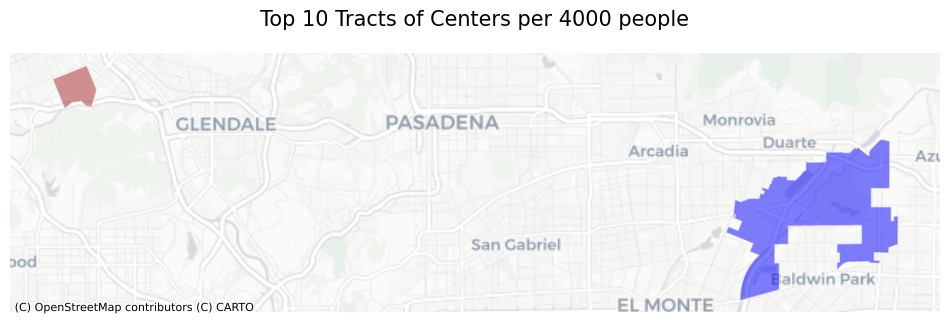

In [60]:
fig,ax = plt.subplots(figsize=(12,10))
donut.plot(ax=ax,
            color='brown',
            edgecolor='white',
            alpha=0.5)

diamond.plot(ax=ax,
            color='blue',
            edgecolor='white',
            alpha=0.5)
# title
ax.set_title('Top 10 Tracts of Centers per 4000 people',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

### Conduct Global Spatial Autocorrelation using Moran's I statistic 

We want to quantify the degree of spatial correlation using Moran's I stat. The moran's I value is the calculated slope of the scatterplot of our "center per 4000" and "centers per 4000 spatial lag" columns. It indicates whether or not we have a positive or negative autocorrelation. 

- **Positive** spatial autocorrelation: high values are close to high values, and/or low values are close to low values
- **Negative** spatial autocorrelation (less common): similar values are far from each other; high values are next to low values, low values are next to high values

In [61]:
y = tractswithCenters.centers_per_4000
moran = Moran(y, wq)
moran.I

np.float64(0.10641033349025616)

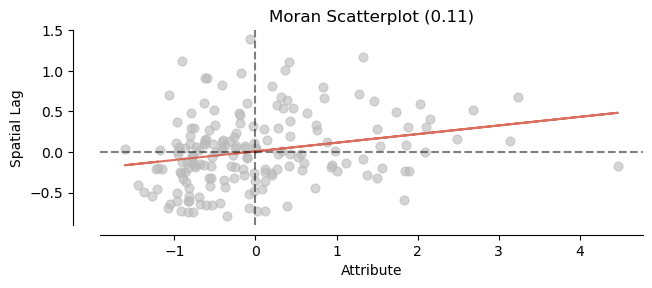

In [62]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

We have a <b> positive spatial </b> autocorrelation, aka neighboring regions tend to have similar values.

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.11', ylabel='Density'>)

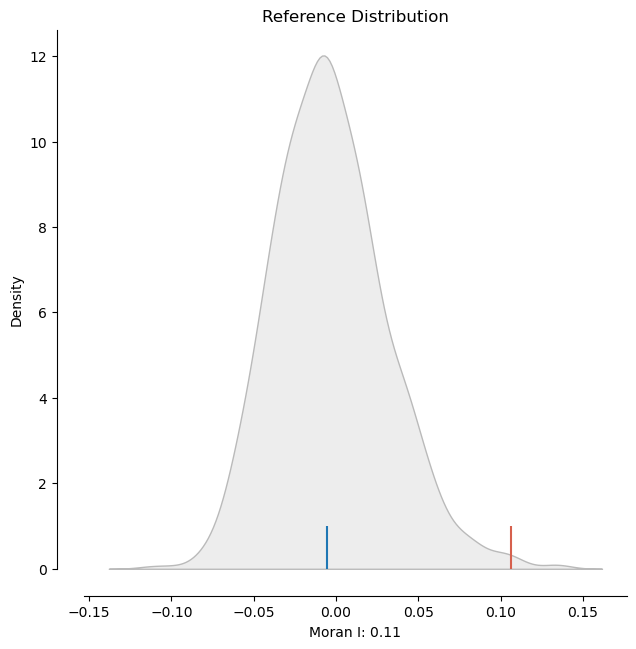

In [63]:
plot_moran_simulation(moran,aspect_equal=False) 

The chart shows that the data are skewed to lower values.

In [64]:
moran.p_sim

np.float64(0.005)

The generated p-value is a very low value, and, by standard terms, it would be deemed statistically significant.  If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.6% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.4% of the random maps would receive a smaller (absolute) value of Moran’s I. 

### Conduct Local Spatial Autocorrelation 

We determined there is a positive spatial autocorrelation between the number of centers in census tracts and their locations. But we have not detected where clusters are. We use Local Indicators of Spatial Association (LISA) to classify areas into four groups: high values near to high values (HH), Low values with nearby low values (LL), Low values with high values in its neighborhood, and vice-versa.

- HH: high center count rate geographies near other high center count rate neighbors
- LL: low center count rate geographies near other low  center count neighbors
- LH (donuts): low center count geographies surrounded by high center count neighbors
- HL (diamonds): high center count geographies surrounded by low center count neighbors

In [65]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

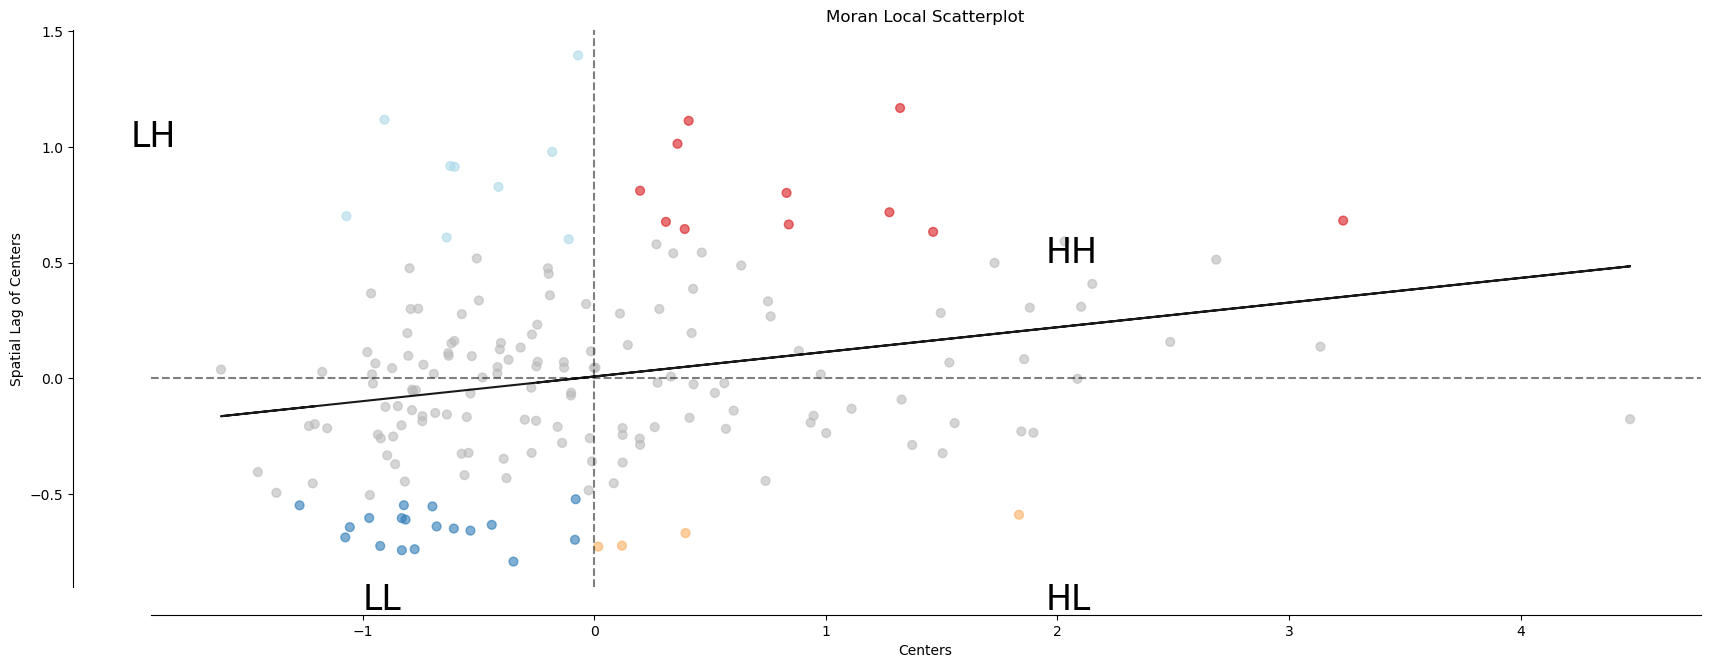

In [66]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Centers")
ax.set_ylabel('Spatial Lag of Centers')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

The colored dots in the above scatterpolot represents the census tracts that have a P-value less that 0.05 in each quadrant. In other words, these are the statisticaly significantly, spatially autocorrelated geographies.

### Create a map comparing p-value or different statistically significant areas

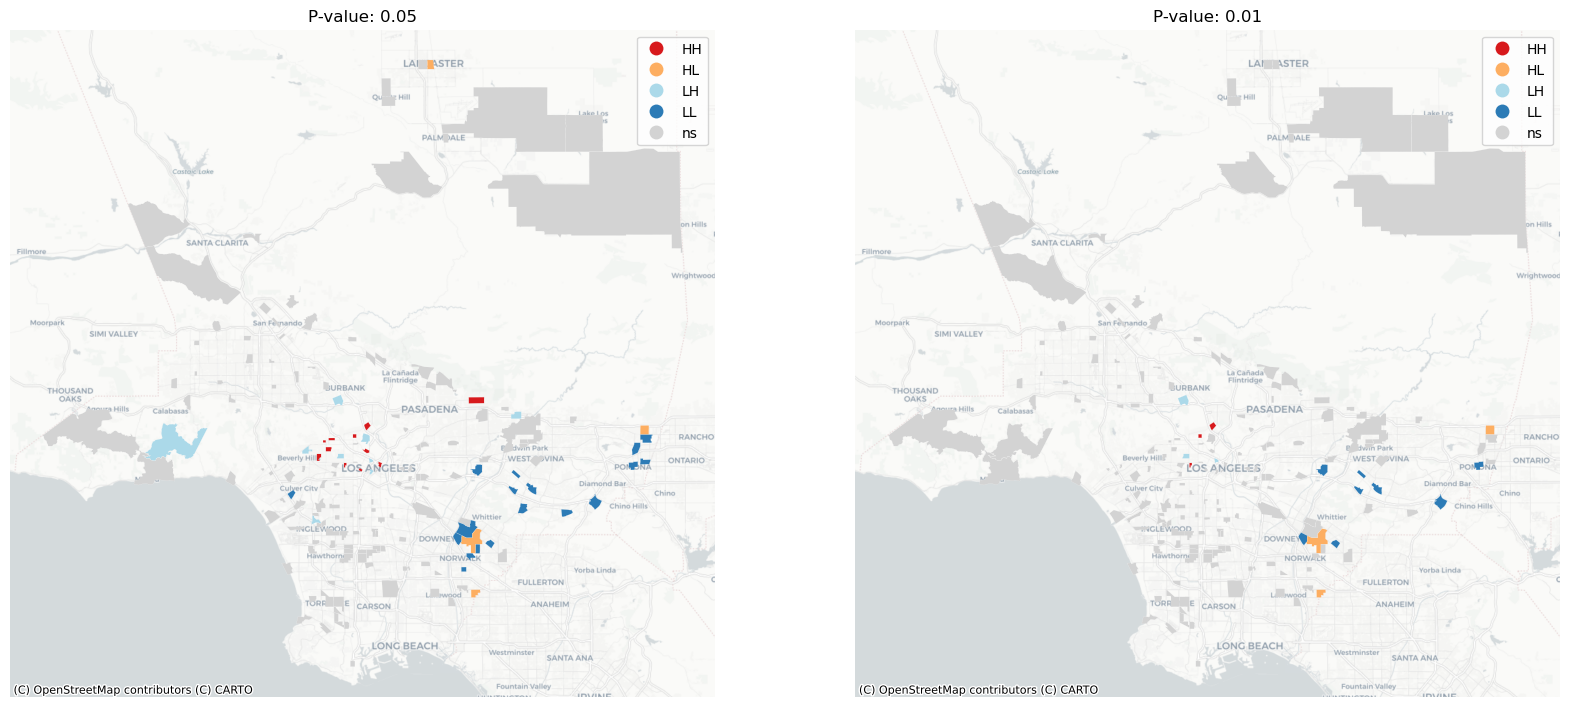

In [67]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, tractswithCenters, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, tractswithCenters, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")


# add a basemap
ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron)
plt.show()

Analysis: We see many HH valued tracts clustered in downtown LA, Beverly Hills, and, Hollywood areas which makes sense considering LA city has the highest count of centers in the county. Low center count geographies near other low center count neighbords are sprinkled around Pomona, Downey, and Norwalk. We will want to look at these areas to understand if they have high heat vulnerability, which may expose the need to include more centers in these tracts. 

### Group Contributions: Mia- cleaned datasets. Zix and Cailyn- organized and added analysis write up. Sienna - mapping. We all worked together on global/local spatial autocorrelation